In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.optimize import curve_fit
from scipy.special import erfc
from scipy.stats import norm

In [7]:
Vt = -60
Vx = 2
tau_max = 6e2

# kinetics
def efun(z):
    ind = np.abs(z) < 1e-4
    efun1 = z*1.
    efun1[ind] = 1 - z[ind]/2
    efun1[~ind] = z[~ind] / (np.exp(z[~ind]) - 1)
    return efun1

def alpha_m(x):
    v1 = x - Vt - 13.
    return 0.32*efun(-0.25*v1)/0.25

def beta_m(x):
    v1 = x - Vt - 40
    return 0.28*efun(0.2*v1)/0.2

def alpha_h(x):
    v1 = x - Vt - 17.
    return 0.128*np.exp(-v1/18.)

def beta_h(x):
    v1 = x - Vt - 40.
    return 4.0/(1 + np.exp(-0.2*v1))

def alpha_n(x):
    v1 = x - Vt - 15.
    return 0.032*efun(-0.2*v1)/0.2

def beta_n(x):
    v1 = x - Vt - 10.
    return 0.5*np.exp(-v1/40)

# slow non-inactivating K+
def p_inf(x):
    v1 = x + 35.
    return 1.0/(1. + np.exp(-0.1*v1))

def tau_p(x):
    v1 = x + 35.
    return tau_max/(3.3*np.exp(0.05*v1) + np.exp(-0.05*v1))

# to generate burst
# high-threshold Ca2+
def alpha_q(x):
    v1 = x + 27
    return 0.055*efun(-v1/3.8)*3.8

def beta_q(x):
    v1 = x + 75
    return 0.94*np.exp(-v1/17)

def alpha_r(x):
    v1 = x + 13
    return 0.000457*np.exp(-v1/50)

def beta_r(x):
    v1 = x + 15
    return 0.0065/(1 + np.exp(-v1/28))

def u_inf(x):
    v1 = x + Vx + 81
    return 1/(1 + np.exp(v1/4))

def tau_u(x):
    v1 = x + Vx + 84
    v2 = x + Vx + 113.2
    return 30.8/3.7 + (211.4 + np.exp(v2/5))/(3.7*(1 + np.exp(v1/3.2)))

def tau_n(x):
     return 1/(alpha_n(x) + beta_n(x))
def n_inf(x):
    return alpha_n(x)/(alpha_n(x) + beta_n(x))
def tau_m(x):
    return 1/(alpha_m(x) + beta_m(x))
def m_inf(x):
    return alpha_m(x)/(alpha_m(x) + beta_m(x))
def tau_h(x):
    return 1/(alpha_h(x) + beta_h(x))
def h_inf(x):
    return alpha_h(x)/(alpha_h(x) + beta_h(x))
def tau_q(x):
    return 1/(alpha_q(x) + beta_q(x))
def q_inf(x):
    return alpha_q(x)/(alpha_q(x) + beta_q(x))
def tau_r(x):
    return 1/(alpha_r(x) + beta_r(x))
def r_inf(x):
    return alpha_r(x)/(alpha_r(x) + beta_r(x))

/home/pedro/.local/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


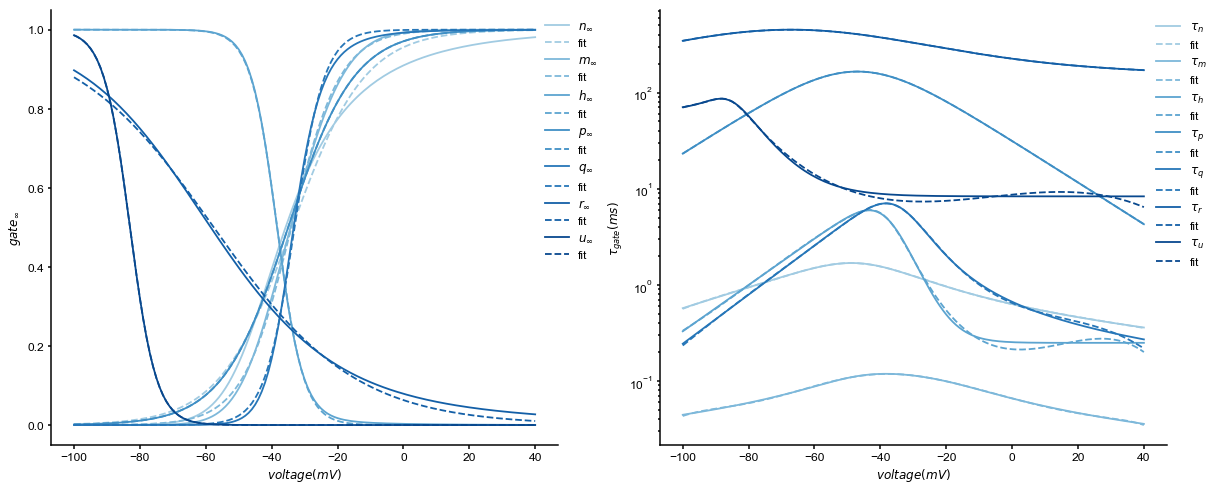

In [3]:
V = np.linspace(-100,40,141)

label_inf = [r'$n_{\infty}$',r'$m_{\infty}$',r'$h_{\infty}$',r'$p_{\infty}$',
             r'$q_{\infty}$',r'$r_{\infty}$',r'$u_{\infty}$']
label_tau = [r'$\tau_n$',r'$\tau_m$',r'$\tau_h$',r'$\tau_p$',r'$\tau_q$',r'$\tau_r$',r'$\tau_u$']
y_inf = [n_inf(V),m_inf(V),h_inf(V),p_inf(V),q_inf(V),r_inf(V),u_inf(V)]
y_tau = [tau_n(V),tau_m(V),tau_h(V),tau_p(V),tau_q(V),tau_r(V),tau_u(V)]

# functions to approximate steady statesand time constants
def sigmoid(x,a,b):
    return 1/(1+np.exp(-a*x+b))

expansion_degree = 3

if expansion_degree == 3:
    def tau_fun(x,a,b,c,d,e,f,g,h):
        y = x - a
        return b/(np.exp(-(c*y+d*y**2+e*y**3)) + np.exp(f*y+g*y**2+h*y**3))
else:
    def tau_fun(x,a,b,c,d,e,f):
        y = x - a
        return b/(np.exp(-(c*y+d*y**2)) + np.exp(e*y+f*y**2))

################
# plotting
col_offset = 4
num_colors = len(label_inf)+col_offset
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_offset,num_colors)]

from matplotlib.backends.backend_pdf import PdfPages

# with PdfPages('pospischil2008_tau_gate_gate_inf.pdf') as pdf:

fig = plt.figure(figsize=(20,8))

popt_inf_ls = []
popt_tau_ls = []
for i in range(len(label_inf)):

    # optimisation and plotting
    plt.subplot(121)
    popt, _ = curve_fit(sigmoid, V, y_inf[i])
    popt_inf_ls.append(popt)
    plt.plot(V,y_inf[i], color=col1[i], label=label_inf[i])
    plt.plot(V, sigmoid(V, *popt), color=col1[i], ls='--', label='fit')
    plt.xlabel(r'$voltage (mV)$')
    plt.ylabel(r'$gate_{\infty}$')
    ax = plt.gca()
    ax.legend(bbox_to_anchor=(1.1, 1), loc='upper right')

    plt.subplot(122)
    if expansion_degree == 3:
        p0 = [V[np.argmax(y_tau[i])],np.max(y_tau[i]),0,0,0,0,0,0]
    else:
        p0 = [V[np.argmax(yy)],np.max(y_tau[m]),0.5,0,0.5,0]
    popt, _ = curve_fit(tau_fun, V, y_tau[i], p0=p0)
    popt_tau_ls.append(popt)
    plt.semilogy(V,y_tau[i],label=label_tau[i],color=col1[i])
    plt.plot(V, tau_fun(V, *popt), color=col1[i], ls='--', label='fit')
    plt.xlabel(r'$voltage (mV)$')
    plt.ylabel(r'$\tau_{gate} (ms)$')
    ax = plt.gca()
    ax.legend(bbox_to_anchor=(1.1, 1), loc='upper right')

plt.show()
#     pdf.savefig()
plt.close()

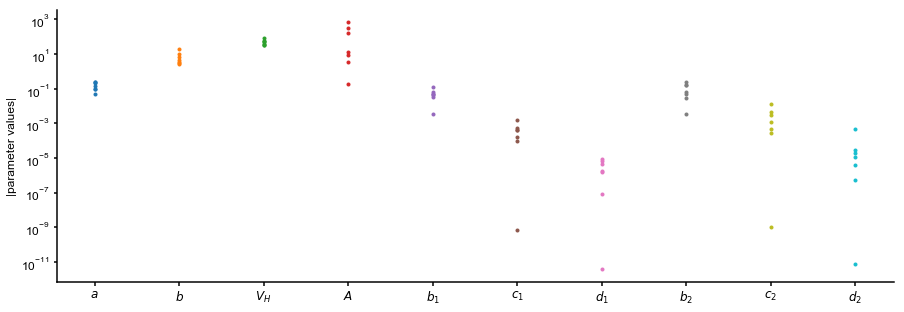

In [4]:
if expansion_degree == 3:
    params_labels = [r'$a$', r'$b$', r'$V_H$', r'$A$', r'$b_1$', r'$c_1$', r'$d_1$', r'$b_2$', r'$c_2$', r'$d_2$']
else:
    params_labels = [r'$a$', r'$b$', r'$V_H$', r'$A$', r'$b_1$', r'$c_1$', r'$b_2$', r'$c_2$']

# with PdfPages('pospischil2008_tau_gate_gate_inf_params.pdf') as pdf:

fig = plt.figure(figsize=(15,5))
popt_mat = np.concatenate((np.asarray(popt_inf_ls), np.asarray(popt_tau_ls)),axis=1)
for i in range(len(params_labels)):
    plt.semilogy(i*np.ones(len(popt_mat[:,i])),np.abs(popt_mat[:,i]),'o')
plt.ylabel('|parameter values|')
ax = plt.gca()
ax.set_xticks(np.linspace(0,len(params_labels)-1,len(params_labels)))
ax.set_xticklabels(params_labels)

plt.show()
#     pdf.savefig()
plt.close()

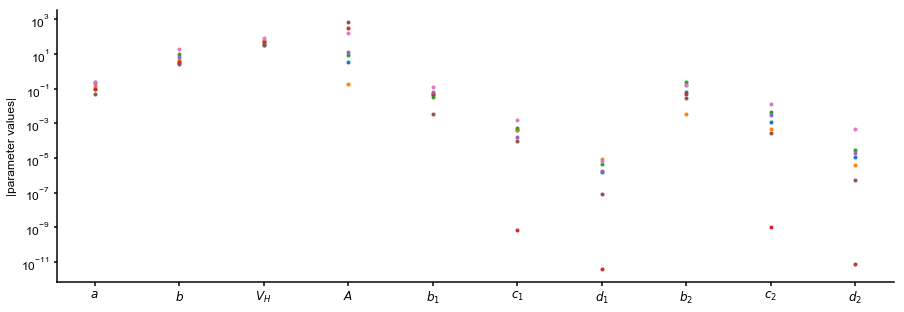

In [5]:
if expansion_degree == 3:
    params_labels = [r'$a$', r'$b$', r'$V_H$', r'$A$', r'$b_1$', r'$c_1$', r'$d_1$', r'$b_2$', r'$c_2$', r'$d_2$']
else:
    params_labels = [r'$a$', r'$b$', r'$V_H$', r'$A$', r'$b_1$', r'$c_1$', r'$b_2$', r'$c_2$']

# with PdfPages('pospischil2008_tau_gate_gate_inf_params.pdf') as pdf:

fig = plt.figure(figsize=(15,5))
popt_mat = np.concatenate((np.asarray(popt_inf_ls), np.asarray(popt_tau_ls)),axis=1)
for i in range(len(label_inf)):
    plt.semilogy(np.linspace(0,len(params_labels)-1,len(params_labels)),np.abs(popt_mat[i,:]),'o')
plt.ylabel('|parameter values|')
ax = plt.gca()
ax.set_xticks(np.linspace(0,len(params_labels)-1,len(params_labels)))
ax.set_xticklabels(params_labels)

plt.show()
#     pdf.savefig()
plt.close()

/home/pedro/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


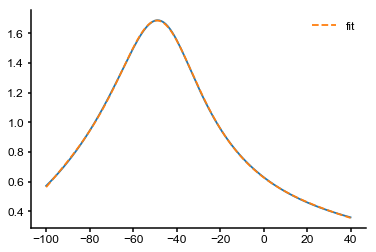

In [6]:
if expansion_degree == 3:
    def tau_fun(x,a,b,c,d,e,f,g,h):
        y = x - a
        return b/(np.exp(-(c*y+d*y**2+e*y**3)) + np.exp(f*y+g*y**2+h*y**3))
else:
    def tau_fun(x,a,b,c,d,e,f):
        y = x - a
        return b/(np.exp(-(c*y+d*y**2)) + np.exp(e*y+f*y**2))

####
# # compute jacobian
# import sympy as sp

# a,b,c,d,e,f,g,h = sp.symbols('a,b,c,d,e,f,g,h')

# def jac_tau_fun_sp(x):
#     FUNC = b/(sp.exp((c*(x - a)+d*(x - a)**2+e*(x - a)**3)) + sp.exp(f*(x - a)+g*(x - a)**2+h*(x - a)**3))
#     d_a = sp.diff(FUNC,a)
#     d_b = sp.diff(FUNC,b)
#     d_c = sp.diff(FUNC,c)
#     d_d = sp.diff(FUNC,d)
#     d_e = sp.diff(FUNC,e)
#     d_f = sp.diff(FUNC,f)
#     d_g = sp.diff(FUNC,g)
#     d_h = sp.diff(FUNC,h)  
#     return [d_a,d_b,d_c,d_d,d_e,d_f,d_g,d_h]

# df = sp.lambdify(((a,b,c,d,e,f,g,h),), jac_tau_fun_sp(v1))

# def jac_tau_fun(v,x1,x2,x3,x4,x5,x6,x7,x8):
#     n = np.size(V)
#     df1 = np.zeros((n,8))
#     for i in range(n):
#         df = sp.lambdify(((a,b,c,d,e,f,g,h),), jac_tau_fun_sp(v[i]))
#         df1[i,:] = df((x1,x2,x3,x4,x5,x6,x7,x8))
#     return df1
####

m=0
yy = y_tau[m]
if expansion_degree == 3:
    p0 = [V[np.argmax(yy)],np.max(y_tau[m]),0,0,0,0,0,0]
else:
    p0 = [V[np.argmax(yy)],np.max(y_tau[m]),0.5,0,0.5,0]
popt, _ = curve_fit(tau_fun, V, yy, p0=p0)
# popt, _ = curve_fit(tau_fun, V, yy, p0=p0, maxfev=30000,ftol=1.49012e-30)

plt.plot(V,yy)
plt.plot(V, tau_fun(V, *popt), '--', label='fit')
# plt.ylim([0,10])
ax = plt.gca()
ax.legend()
plt.show()